In [1]:
import os
import pickle
import numpy as np
import nltk
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from pyidaungsu import tokenize as myanmar_tokenize
from nltk.tokenize import word_tokenize
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

KeyboardInterrupt: 

In [ ]:
# Define your dataset paths and directories
BASE_DIR = 'C:/Users/arker/myanmar text'  # Replace with the path to your dataset
WORKING_DIR = 'C:/Users/arker/myanmar text/working'  # Replace with your working directory


In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# Extract features from images
features = {}
image_directory = os.path.join(BASE_DIR, 'Images')

In [ ]:
for img_name in tqdm(os.listdir(image_directory)[:730]):  # Load only 100 images
    img_path = os.path.join(image_directory, img_name)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

100%|██████████| 686/686 [06:24<00:00,  1.78it/s]


In [ ]:
# Store features in a pickle file
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features730.pkl'), 'wb'))

In [ ]:
# Load features from pickle
with open(os.path.join(WORKING_DIR, 'features730.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
# Load Myanmar text captions
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r', encoding='utf-8') as f:
    captions_doc = f.readlines()#[:610]  # Load only 555 captions

In [ ]:
# Create a mapping of image IDs to captions
mapping = {}
for line in tqdm(captions_doc):
    tokens = line.strip().split(',')
    if len(tokens) < 2:
        continue
    image_id, caption = tokens[0], tokens[1]
    image_id = image_id.split('.')[0]
    if image_id not in mapping:
        mapping[image_id] = []

    # Tokenize Myanmar text using NLTK's word_tokenize
    caption_tokens = word_tokenize(caption)

    # Join the tokenized text into a single string
    caption = ' '.join(caption_tokens)

    # Perform additional preprocessing if needed
    caption = caption.lower()
    caption = 'startseq ' + caption + ' endseq'

    mapping[image_id].append(caption)

100%|██████████| 3432/3432 [00:00<00:00, 4009.42it/s]


In [ ]:
# Create a list of all captions
all_captions = []
for key in mapping:
    all_captions.extend(mapping[key])

In [ ]:
# Tokenize the Myanmar text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Get the maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
print(max_length)

15


In [ ]:
# Define train and test split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# Define the data generator (you can modify it as needed)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Ensure the key exists in the features dictionary
                    if key in features:
                        X1.append(features[key][0])
                        X2.append(in_seq)
                        y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
# Define the model architecture
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

In [ ]:
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

In [ ]:
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

In [ ]:
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
# Plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
# Train the model
#epochs = 100
#batch_size = 32
#steps = len(train) // batch_size

#for i in range(epochs):
    #generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    #model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs = 170
batch_size = 32
steps = len(train) // batch_size
history = {'loss': [], 'accuracy': []}

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    h = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=0)
    loss = h.history['loss'][0]
    history['loss'].append(loss)
    total_correct = 0
    total_samples = 0
    for _ in range(steps):
        batch_x, batch_y = next(generator)
        predictions = model.predict(batch_x)
        batch_accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(batch_y, axis=1))
        total_correct += batch_accuracy * len(batch_x)
        total_samples += len(batch_x)
    accuracy = total_correct / total_samples
    history['accuracy'].append(accuracy)
    print(f"Epoch {i+1}/{epochs} - Loss: {loss:.4f} - Accuracy: {accuracy:.4f}")

37/37 [==============================] - 2s 41ms/step
Epoch 1/150 - Loss: 3.8456 - Accuracy: 0.1640
37/37 [==============================] - 1s 39ms/step
Epoch 2/150 - Loss: 3.1303 - Accuracy: 0.3069
37/37 [==============================] - 1s 38ms/step
Epoch 3/150 - Loss: 2.5182 - Accuracy: 0.3575
37/37 [==============================] - 2s 40ms/step
Epoch 4/150 - Loss: 2.2499 - Accuracy: 0.3639
37/37 [==============================] - 1s 38ms/step
Epoch 5/150 - Loss: 1.9786 - Accuracy: 0.4755
37/37 [==============================] - 1s 37ms/step
Epoch 6/150 - Loss: 1.6402 - Accuracy: 0.5394
37/37 [==============================] - 2s 46ms/step
Epoch 7/150 - Loss: 1.4480 - Accuracy: 0.5690
37/37 [==============================] - 2s 41ms/step
Epoch 8/150 - Loss: 1.2621 - Accuracy: 0.5955
37/37 [==============================] - 2s 42ms/step
Epoch 9/150 - Loss: 1.2189 - Accuracy: 0.6109
37/37 [==============================] - 2s 45ms/step
Epoch 10/150 - Loss: 1.2216 - Accuracy: 0.6492

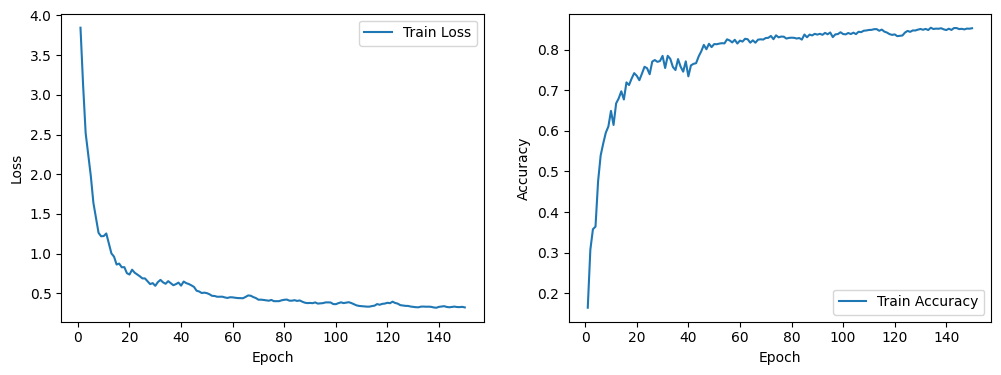

In [ ]:
# Plot the training loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), history['accuracy'], label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Save the model
model.save(os.path.join(WORKING_DIR, 'best_model_730.h5'))

In [ ]:
# Save the tokenizer as a pickle file
def save_tokenizer(tokenizer, path):
    with open(path, 'wb') as tokenizer_file:
        pickle.dump(tokenizer, tokenizer_file)

# Define the path where you want to save the tokenizer
tokenizer_path = os.path.join(WORKING_DIR, 'tokenization_730.pkl')

# Save the tokenizer
save_tokenizer(tokenizer, tokenizer_path)

# Confirm that the tokenizer has been saved
print(f'Tokenizer saved as {tokenizer_path}')

Tokenizer saved as C:/Users/arker/myanmar text/working\tokenization_686_1.pkl


In [ ]:
# Define a function to map indices back to words in the tokenizer
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [ ]:
# Generate captions for an image
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq '
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == ' endseq':
            break
    return in_text

In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 69/69 [01:32<00:00,  1.34s/it]

BLEU-1: 0.391304
BLEU-2: 0.335093
